#### End-to-End Machine Learning Pipeline
#### Customer Churn Prediction using Scikit-learn

**Objective:**  
Build a reusable and production-ready ML pipeline using Scikit-learn's Pipeline API to predict customer churn.

**Dataset:**  
Telco Customer Churn Dataset

##### Import Libraries


In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import joblib

##### Step 1: Load Dataset

In [17]:
# Load Data (Using the standard Telco Churn URL for reproducibility)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.head()

# if you want to save the dataset locally into csv
# df.to_csv("data/telco_churn.csv", index=False)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# Check data types
# print(df["TotalCharges"].dtype)

##### Step 2: Basic Data Cleaning

In [20]:
# Convert TotalCharges to numeric, coerce errors to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Drop missing values
df.dropna(inplace=True)

# Check target distribution
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

##### Step 3: Feature and Target Separation


In [21]:
# Define features and target
x = df.drop(['customerID', "Churn"], axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})

##### Step 4: Train-Test Split


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

##### Step 5: Identify Numerical and Categorical Features


In [23]:
numerical_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

categorical_features = [
    col for col in X_train.columns if col not in numerical_features
]


In [24]:
categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

##### Step 6: Build Preprocessing Pipelines

In [25]:
# Numerical pipeline
num_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features)
    ]
)

##### Step 7: Create Full ML Pipelines
Pipelines

In [26]:
# Logistic Regression Pipeline
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

##### Step 8: Hyperparameter Tuning using GridSearchCV
GridSearch (Logistic Regression)

In [27]:
log_reg_params = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
}

log_reg_grid = GridSearchCV(
    log_reg_pipeline,
    param_grid=log_reg_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and can

##### GridSearch (Random Forest)

In [28]:
rf_params = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
}

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5, ...], 'classifier__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold an

##### Step 9: Model Evaluation

In [29]:
best_model = rf_grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.798862828713575
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



##### Visual Evaluation Metrics

**1. Confusion Matrix**

The Confusion Matrix allows you to see the exact count of `True Positives`, `True Negatives`, `False Positives`, and `False Negatives`. This is vital for churn because the cost of a "False Negative" (missing a customer who is about to leave) is usually much higher than a "False Positive."

**2. ROC Curve & AUC**

The **Receiver Operating Characteristic (ROC)** curve shows the trade-off between the True Positive Rate and False Positive Rate. The ```Area Under the Curve (AUC)``` provides an aggregate measure of performance across all possible classification thresholds.

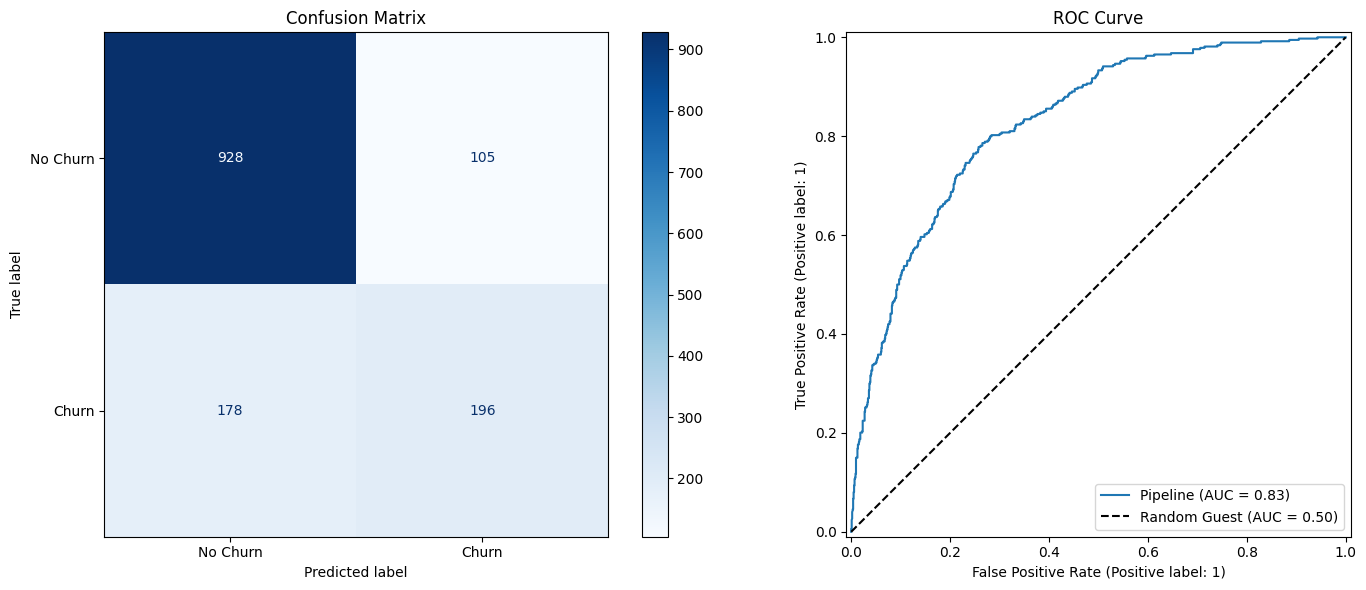

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Set up a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Plot Confusion Matrix
# We use the best_model (Random Forest) from your grid search
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, 
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues,
    ax=ax1
)
ax1.set_title("Confusion Matrix")

# 2. Plot ROC Curve
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test, 
    ax=ax2
)
ax2.set_title("ROC Curve")
# Adding a diagonal line for a random classifier reference
ax2.plot([0, 1], [0, 1], "k--", label="Random Guest (AUC = 0.50)")
ax2.legend()

plt.tight_layout()
plt.show()

##### Step 10: Save the Complete Pipeline

In [36]:
# Save Model
joblib.dump(best_model, "models/churn_pipeline_model.joblib")

['models/churn_pipeline_model.joblib']

##### Step 11: Load Pipeline for Inference

In [37]:
# Load Model
loaded_model = joblib.load("models/churn_pipeline_model.joblib")

##### Adding Feature Importance
In a Random Forest, "Feature Importance" tells us which variables (like ``Contract``, `Tenure`, or `MonthlyCharges`) had the most significant impact on the model's decisions across all the trees in the forest.

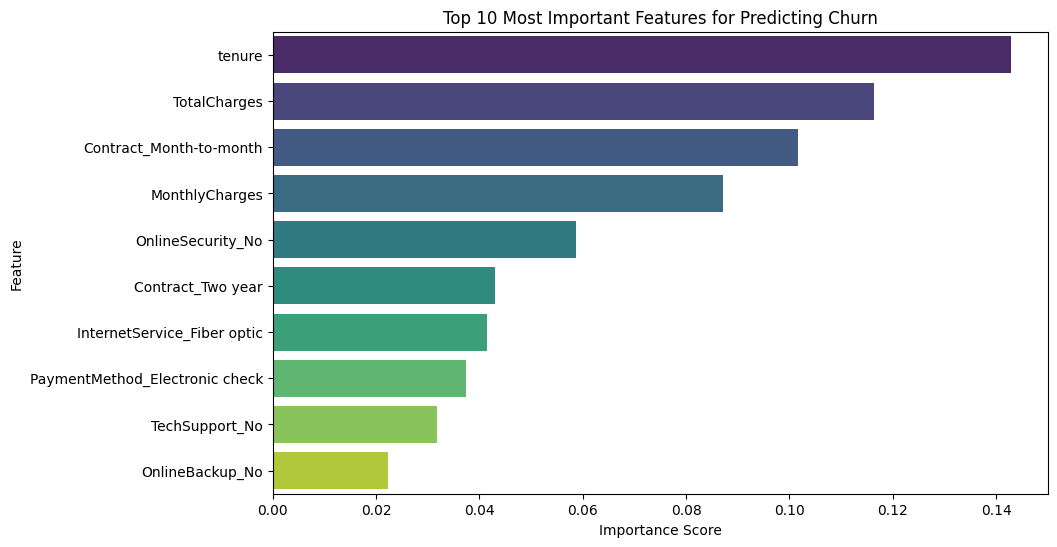

In [39]:
# 1. Extract the classifier and preprocessor from the pipeline
classifier = best_model.named_steps['classifier']
preprocessor = best_model.named_steps['preprocessor']

# 2. Get the feature names after One-Hot Encoding
# Get categorical feature names from the one-hot encoder
cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_features])

# 3. Create a DataFrame for visualization
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# 4. Plot the top 10 features (Updated to fix the FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Fixed: Assigned 'Feature' to hue and set legend=False as per Seaborn guidelines
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette='viridis', 
    hue='Feature', 
    legend=False
)

plt.title('Top 10 Most Important Features for Predicting Churn')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

**Why this is helpful:**

- **Identify Risk Factors:** If Contract_Month-to-month appears at the top, it tells the business that customers without long-term contracts are much more likely to churn.

- **Validate the Model:** If TotalCharges and Tenure are highly ranked, it makes sense logically—the longer a customer stays, the more data the model has to predict their loyalty.

- **Actionable Insights:** You can tell your stakeholders exactly where to focus their retention budget (e.g., "We need to move month-to-month customers to annual plans").

##### Final Notes

##### ✅ Key Takeaways

- Used Scikit-learn Pipelines for clean ML workflow
- Prevented data leakage
- Enabled easy deployment
- Entire preprocessing + model saved as one object

This notebook represents a **production-grade ML pipeline**.
